# Random forest

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import sklearn
import sklearn.ensemble
import sklearn_pandas

import tpot

%matplotlib inline

PATH = os.path.abspath('..')

%load_ext autoreload
%autoreload 2

In [2]:
! ls ../catalogs/

SDSSspecgalsDR14_boada.csv  test-metaldist.csv	train-mass-metal.csv
test-all.csv		    test-oh_p50.csv	train-metaldist.csv
test-mass.csv		    train-all.csv	train-oh_p50.csv
test-mass-metal.csv	    train-mass.csv	train-r-metaldist.csv


In [3]:
df = pd.read_csv(f'{PATH}/catalogs/SDSSspecgalsDR14_boada.csv')
df.head()

,objID,specObjID,ra,dec,z,zErr,velDisp,velDispErr,modelMag_u,modelMagErr_u,...,d4000,d4000_err,bptclass,oh_p2p5,oh_p16,oh_p50,oh_p84,oh_p97p5,lgm_tot_p50,sfr_tot_p50
0,1237648721751376083,534815957734942720,142.944222,0.339306,0.148051,0.000008,191.37130,29.119800,19.23619,0.030150,...,1.301792,0.015150,1,8.875947,8.935274,8.950057,8.978632,9.016094,10.290080,0.759519
1,1237648721220075713,306307479388579840,155.688647,-0.003088,0.062559,0.000008,90.07338,9.302679,18.08446,0.021406,...,1.356608,0.015810,1,9.007464,9.045025,9.082232,9.094326,9.099128,10.504520,0.340369
2,1237648705657962690,333377181507938304,199.753695,0.996691,0.054072,0.000007,54.84515,14.221800,17.96100,0.024077,...,1.346449,0.017711,1,8.722798,8.786467,8.810163,8.844212,8.874462,9.975035,0.195038
3,1237648705657438484,332284266966706176,198.540462,0.921618,0.029709,0.000006,780.97020,195.471100,18.75527,0.047067,...,1.268220,0.067678,1,8.084666,8.193955,8.333026,8.470915,8.565473,8.454908,-0.573657
4,1237648705657438478,332285091600427008,198.534274,0.937417,0.029789,0.000009,0.00000,63.073320,19.13474,0.049963,...,1.282506,0.041716,1,8.161867,8.271518,8.416960,8.538336,8.603781,8.713576,-0.747333


In [4]:
df.columns

Index(['objID', 'specObjID', 'ra', 'dec', 'z', 'zErr', 'velDisp', 'velDispErr',
       'modelMag_u', 'modelMagErr_u', 'modelMag_g', 'modelMagErr_g',
       'modelMag_r', 'modelMagErr_r', 'modelMag_i', 'modelMagErr_i',
       'modelMag_z', 'modelMagErr_z', 'petroR50_r', 'petroR90_r',
       'nii_6584_flux', 'nii_6584_flux_err', 'h_alpha_flux',
       'h_alpha_flux_err', 'oiii_5007_flux', 'oiii_5007_flux_err',
       'h_beta_flux', 'h_beta_flux_err', 'h_delta_flux', 'h_delta_flux_err',
       'd4000', 'd4000_err', 'bptclass', 'oh_p2p5', 'oh_p16', 'oh_p50',
       'oh_p84', 'oh_p97p5', 'lgm_tot_p50', 'sfr_tot_p50'],
      dtype='object')

In [5]:
columns_of_interest = ['modelMag_g', 'modelMag_r', 'modelMag_i', 'oh_p50', 'lgm_tot_p50']
df = df.loc[:, columns_of_interest]

# cut out bad values
df = df[df.lgm_tot_p50 > 0].copy()

In [6]:
X = df[['modelMag_g', 'modelMag_r', 'modelMag_i']]
y = df[['oh_p50', 'lgm_tot_p50']]

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=256)

In [7]:
%%time
reg = sklearn.ensemble.RandomForestRegressor(criterion='mse')

reg.fit(X_train, y_train)

CPU times: user 5.16 s, sys: 48 ms, total: 5.2 s
Wall time: 4.91 s


In [8]:
p = reg.predict(X_test)

# R^2 score
reg.score(X_test, y_test)

0.6348664741783767

In [9]:
def rmse(y1, y2): return np.sqrt(np.mean((y1 - y2)**2, axis=0))

In [10]:
rmse(p, y_test)

oh_p50         0.135568
lgm_tot_p50    0.332202
dtype: float64

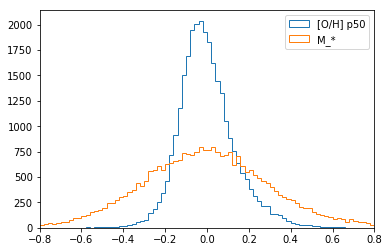

In [11]:
for i in range(2):
    plt.hist(p[:, i] - y_test.values[:, i], bins=100, range=[-1, 1], histtype='step')
plt.xlim(-.8, .8)
plt.legend(['[O/H] p50', 'M_*'])

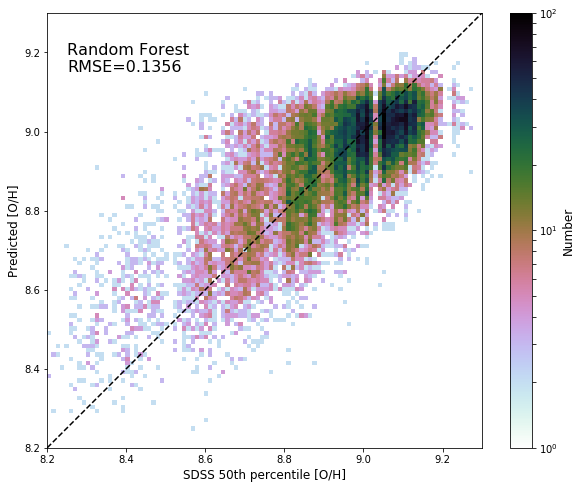

In [13]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
*_, im = ax.hist2d(y_test.values[:, 0], p[:, 0], bins=100, range=[[8.2, 9.3], [8.2, 9.3]], cmap='cubehelix_r', norm=matplotlib.colors.LogNorm(vmin=1, vmax=100))
ax.plot([8.2, 9.3], [8.2, 9.3], c='k', ls='--')
ax.set_aspect(aspect='equal')

ax.text(8.25, 9.15, f'Random Forest\n' f'RMSE={rmse(p, y_test).values[0]:.4f}', fontsize=16)

ax.set_xlabel('SDSS 50th percentile [O/H]', fontsize=12)
ax.set_ylabel('Predicted [O/H]', fontsize=12)
cb = fig.colorbar(im);
cb.set_label('Number', fontsize=12)


fig.savefig(f'{PATH}/results/random-forest_pred-vs-SDSS.pdf')

# TPOT

[TPOT](https://github.com/EpistasisLab/tpot) is a nice genetic automated machine learning tool that builds off `sklearn`. Let's see if we can do better than the Vanilla random forest and compare to our best resnet predictions...

In [17]:
from tpot import TPOTRegressor

In [54]:
tpot = TPOTRegressor(generations=5, population_size=20, verbosity=2, n_jobs=4, random_state=256)

It can only predit 1-d arrays, so let's choose metallicity. 

Note that the output is the negative mean squared error, where $RMSE=0.135 \rightarrow -0.182$ (decision forest) and $RMSE = 0.083 \rightarrow -0.0069$ (resnet)

In [ ]:
tpot.fit(X_train.values, y_train.oh_p50.values)
print(tpot.score(X_test, y_test.oh_p50.values))


Optimization Progress:  17%|█▋        | 20/120 [00:58<20:34, 12.34s/pipeline]

In [ ]:
tpot.export('tpot_metallicity_pipeline.py')

In [ ]:
p_tpot = tpot.predict(X_test)

In [ ]:
plt.hist(p[:, 0] - y_test.values[:, 0], bins=100, range=[-1, 1], histtype='step', label='Random Forest')
plt.hist(p_tpot - y_test.oh_p50.values, bins=100, range=[-1, 1], histtype='step', label='TPOT')
plt.axvline(0)
plt.xlim(-.8, .8)
plt.legend();

# XGBoost

XGBoost became super popular in 2015 [all](http://blog.kaggle.com/2015/12/21/rossmann-store-sales-winners-interview-1st-place-gert/) [over](https://no2147483647.wordpress.com/2014/09/17/winning-solution-of-kaggle-higgs-competition-what-a-single-model-can-do/) [Kaggle](https://github.com/daxiongshu/tradeshift-text-classification) [.](http://blog.kaggle.com/2015/12/03/dato-winners-interview-1st-place-mad-professors/) It builds on the idea of [gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting).

In [43]:
import xgboost

In [46]:
xg_data = xgboost.DMatrix(X_train.values)
booster = xgboost.Booster({'nthread':4}, model_file = f'{PATH}/tmp/metal_xgboost.model')

XGBoostError: b'[16:48:25] src/io/local_filesys.cc:199: Check failed: allow_null  LocalFileSystem::Open "/home/jw740/projects/galaxy-cnns/tmp/metal_xgboost.model": No such file or directory\n\nStack trace returned 10 entries:\n[bt] (0) /home/jw740/anaconda3/envs/fastai/lib/python3.6/site-packages/xgboost/./lib/libxgboost.so(dmlc::StackTrace[abi:cxx11]()+0x56) [0x7fa619a4e1b6]\n[bt] (1) /home/jw740/anaconda3/envs/fastai/lib/python3.6/site-packages/xgboost/./lib/libxgboost.so(dmlc::io::LocalFileSystem::Open(dmlc::io::URI const&, char const*, bool)+0x63a) [0x7fa619c2f2da]\n[bt] (2) /home/jw740/anaconda3/envs/fastai/lib/python3.6/site-packages/xgboost/./lib/libxgboost.so(dmlc::Stream::Create(char const*, char const*, bool)+0x166) [0x7fa619c21386]\n[bt] (3) /home/jw740/anaconda3/envs/fastai/lib/python3.6/site-packages/xgboost/./lib/libxgboost.so(XGBoosterLoadModel+0x18) [0x7fa619c02818]\n[bt] (4) /home/jw740/anaconda3/envs/fastai/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(ffi_call_unix64+0x4c) [0x7fa6e11f5c9c]\n[bt] (5) /home/jw740/anaconda3/envs/fastai/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(ffi_call+0x165) [0x7fa6e11f4de5]\n[bt] (6) /home/jw740/anaconda3/envs/fastai/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(_ctypes_callproc+0x283) [0x7fa6e11ed183]\n[bt] (7) /home/jw740/anaconda3/envs/fastai/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(+0x985f) [0x7fa6e11e485f]\n[bt] (8) /home/jw740/anaconda3/envs/fastai/bin/../lib/libpython3.6m.so.1.0(_PyObject_FastCallDict+0x8b) [0x7fa6e77209cb]\n[bt] (9) /home/jw740/anaconda3/envs/fastai/bin/../lib/libpython3.6m.so.1.0(+0x165188) [0x7fa6e7813188]\n\n'